/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


170498071/170498071 [==============================] - 2s 0us/step


KeyboardInterrupt: 

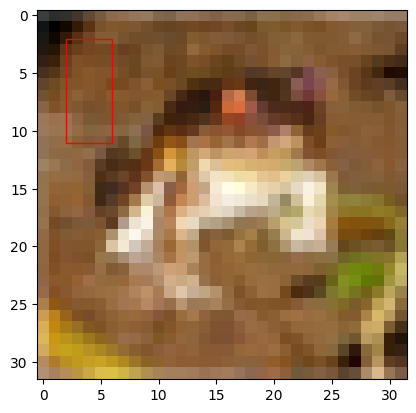

In [ ]:
import numpy as np
import gym
from gym import spaces
from skimage.transform import resize
from keras.datasets import cifar10
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Defining a custom OpenAI gym environment for object detection
class ObjectDetectionEnv(gym.Env):
    def __init__(self, image, ground_truth_bbox):
        super(ObjectDetectionEnv, self).__init__()
        self.image = image # input image
        self.ground_truth_bbox = ground_truth_bbox # ground truth bounding box
        self.current_bbox = [0, 0, 32, 32] # initial bounding box

        # Action Space : 6 discrete actions : left, right, up, down, expand, shrink
        self.action_space = spaces.Discrete(6)

        # Observation Space : Shape of the image (32x32x3)
        self.observation_space = spaces.Box(low=0, high=255, shape=(32, 32, 3), dtype=np.uint8)

    # Reset environment to initial state
    def reset(self):
        self.current_bbox = [0, 0, 32, 32] # Reset bounding box to initial position
        return self.image # Return the initial image

    # Function to update the environment based on action taken
    def step(self, action):
        if action == 0:  # move left
            self.current_bbox[0] -= 1
        elif action == 1:  # move right
            self.current_bbox[0] += 1
        elif action == 2:  # move up
            self.current_bbox[1] -= 1
        elif action == 3:  # move down
            self.current_bbox[1] += 1
        elif action == 4:  # expand bbox
            self.current_bbox[2] += 1
            self.current_bbox[3] += 1
        elif action == 5:  # shrink bbox
            self.current_bbox[2] -= 1
            self.current_bbox[3] -= 1

        # Perform clipping to keep bounding box coordinates in bounds
        self.current_bbox[0] = np.clip(self.current_bbox[0], 0, 32)
        self.current_bbox[1] = np.clip(self.current_bbox[1], 0, 32)
        self.current_bbox[2] = np.clip(self.current_bbox[2], 0, 32)
        self.current_bbox[3] = np.clip(self.current_bbox[3], 0, 32)

        # Calculate reward based on IoU (Intersection over Union)
        reward = self.compute_iou(self.current_bbox, self.ground_truth_bbox)
        # If reward is more than desired value, we stop the execution
        done = (reward > 0.9)

        return self.image, reward, done, {}

    # Compute the Intersection over Union (IoU) between two bounding boxes
    def compute_iou(self, box1, box2):
        xA = max(box1[0], box2[0])
        yA = max(box1[1], box2[1])
        xB = min(box1[2], box2[2])
        yB = min(box1[3], box2[3])

        # Calculate the area of intersection rectangle
        interArea = max(0, xB - xA) * max(0, yB - yA)
        # Calculate the area of both the prediction and ground-truth rectangles
        box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        # Compute the IoU
        iou = interArea / float(box1Area + box2Area - interArea)
        return iou

    # Rendering the bounding box on the image for visualization
    def render_bbox(self, episode, step):
        fig, ax = plt.subplots(1)
        ax.imshow(self.image)
        rect = patches.Rectangle((self.current_bbox[0], self.current_bbox[1]),
                                 self.current_bbox[2] - self.current_bbox[0],
                                 self.current_bbox[3] - self.current_bbox[1],
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.savefig(f'output/episode_{episode}_step_{step}.png')
        plt.close(fig)

# Creating a output directory to save the rendered bounding box images
os.makedirs('output', exist_ok=True)

# Loading the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Selecting a sample image and defining its ground truth bounding box (Center of image)
image = train_images[0]
ground_truth_bbox = [6, 6, 26, 26]
env = ObjectDetectionEnv(image, ground_truth_bbox)

# Q-learning Agent
class QLearningAgent:
    def __init__(self, action_size, state_size, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.995, exploration_min=0.01):
        self.action_size = action_size # Number of possible actions
        self.state_size = state_size # Size of the state space
        self.q_table = np.zeros((state_size, action_size)) # Initialize Q-table
        self.learning_rate = learning_rate # Learning rate
        self.discount_factor = discount_factor # Discount factor for future rewards
        self.exploration_rate = exploration_rate # Initial exploration rate
        self.exploration_decay = exploration_decay # Decay rate for exploration
        self.exploration_min = exploration_min # Minimum exploration rate

    # Choose an action based on the exploration-exploitation trade-off
    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_size) # Explore: choose a random action
        return np.argmax(self.q_table[state]) # Exploit: choose the action with the highest Q-value

    # Update the Q-value for the given state-action pair
    def update_q_value(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state]) # Best action for the next state
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action] # TD target
        self.q_table[state, action] += self.learning_rate * (td_target - self.q_table[state, action]) # Update Q-value

        # Decay the exploration rate
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

# Initialize action and state sizes for the Q-learning agent
action_size = env.action_space.n
state_size = env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2]
agent = QLearningAgent(action_size, state_size)

# Number of episodes for training
num_episodes = 10

# Training loop
for e in range(num_episodes):
    state = env.reset() # Reset environment to initial state
    state = state.flatten() # Flatten the state representation
    done = False
    total_reward = 0

    step = 0
    while not done:
        action = agent.choose_action(state) # Choose an action
        next_state, reward, done, _ = env.step(action) # Take a step in the environment
        next_state = next_state.flatten() # Flatten the next state representation

        agent.update_q_value(state, action, reward, next_state) # Update Q-value
        state = next_state # Move to the next state
        total_reward += reward

        env.render_bbox(e, step) # Render the bounding box for visualization
        step += 1

    print(f"Episode: {e+1}/{num_episodes}, Total Reward: {total_reward}")

print("Training completed!")
